In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("./project_data.csv")

In [2]:
import seaborn
seaborn.set()

In [3]:
def prep_data(df):
    X = df.copy()
    X.drop(columns = ['c10'], inplace=True)
    
    X.loc[X.b1 == -1, 'b1'] = np.nan
    X['b1'] = (X.b1 == 'yes').astype(float)
    X['b2'] = (X.b2 == 'yes').astype(float)
    
    X.loc[X.c3 == 'unknown','c3'] = np.nan
    X['c3'] = (X.c3 == 'True').astype(float)
    X['c4'] = (X.c4 == 'new').astype(float)
    X['c8'] = (X.c8 == 'yes').astype(float)
    
    y = (X.pop('successful_sell') == 'yes').astype(int)
    X['school'] = X.school.str.split().str[0].astype(float)
    
    return X, y

In [4]:
X, y = prep_data(df)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, train_size=.75)

In [6]:
X_train.columns

Index(['age', 'b1', 'b2', 'c3', 'c4', 'c8', 'dow', 'employment', 'i1', 'i2',
       'i3', 'i4', 'i5', 'marriage-status', 'month', 'n2', 'n3', 'n4', 'n5',
       'n6', 'school'],
      dtype='object')

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce

import xgboost

In [8]:
ct = ColumnTransformer([
    ('employment', ce.OneHotEncoder(use_cat_names=True), ['employment']),
    ('marriage-status', ce.OneHotEncoder(use_cat_names=True), ['marriage-status']),
    
    ('passthrough', 'passthrough', ['age','b1', 'b2','c4', 'i1', 'i2', 'i3', 'i4', 'i5', 'c8', 'school', 'n2', 'n4', 'n6',]),
    ('drop', 'drop', ['n3', 'n5', 'c3']),
], remainder = 'drop')
clf = xgboost.XGBClassifier(learning_rate=.1, use_label_encoder=False, eval_metric='logloss')

In [9]:
Xt_train = pd.DataFrame(ct.fit_transform(X_train), columns =  ct.get_feature_names(), index = X_train.index)
Xt_test = pd.DataFrame(ct.transform(X_test), columns =  ct.get_feature_names(), index = X_test.index)

In [10]:
Xt_train.head().T

,19183,32597,38656,526,41002
employment__employment_assistant,1.000,1.000,0.000,1.000,0.000
employment__employment_laborer,0.000,0.000,1.000,0.000,0.000
employment__employment_engineer,0.000,0.000,0.000,0.000,1.000
employment__employment_management,0.000,0.000,0.000,0.000,0.000
employment__employment_none,0.000,0.000,0.000,0.000,0.000
employment__employment_hobbyist,0.000,0.000,0.000,0.000,0.000
employment__employment_customer service,0.000,0.000,0.000,0.000,0.000
employment__employment_student,0.000,0.000,0.000,0.000,0.000
employment__employment_leisure,0.000,0.000,0.000,0.000,0.000
employment__employment_self-employed,0.000,0.000,0.000,0.000,0.000


In [11]:
params = clf.get_xgb_params()

In [12]:
cv_results = xgboost.cv(params, xgboost.DMatrix(Xt_train, y_train), num_boost_round = 100, early_stopping_rounds=10, metrics = 'logloss')
cv_results

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.626923,0.000198,0.627791,0.000261
1,0.572786,0.000338,0.574335,0.000500
2,0.527849,0.000431,0.530158,0.000598
3,0.490126,0.000513,0.493156,0.000731
4,0.458139,0.000607,0.461885,0.000916
5,0.431001,0.000731,0.435440,0.001052
6,0.407714,0.000860,0.412807,0.001206
7,0.387773,0.000918,0.393481,0.001287
8,0.370467,0.000966,0.376858,0.001238
9,0.355454,0.000989,0.362464,0.001478


In [13]:
clf.set_params(n_estimators = len(cv_results))

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=49, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.utils.fixes import loguniform
model = RandomizedSearchCV(
    Pipeline([("ct", ct), ('clf', clf)]),
    param_distributions=dict(
        clf__subsample=scipy.stats.uniform(.5, .5),
        clf__colsample_bytree=scipy.stats.uniform(.5,.5),
        clf__max_depth=np.arange(4,10,1),
        clf__reg_alpha = loguniform(.01,100),
    ),
    n_iter=50,
    cv=5, 
    verbose = 2,
    n_jobs = 1,
)
model.fit(X_train, y_train,)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END clf__colsample_bytree=0.6410347411839632, clf__max_depth=9, clf__reg_alpha=1.1076692214069541, clf__subsample=0.7336470846167793; total time=  10.9s
[CV] END clf__colsample_bytree=0.6410347411839632, clf__max_depth=9, clf__reg_alpha=1.1076692214069541, clf__subsample=0.7336470846167793; total time=  40.1s
[CV] END clf__colsample_bytree=0.6410347411839632, clf__max_depth=9, clf__reg_alpha=1.1076692214069541, clf__subsample=0.7336470846167793; total time=   0.9s
[CV] END clf__colsample_bytree=0.6410347411839632, clf__max_depth=9, clf__reg_alpha=1.1076692214069541, clf__subsample=0.7336470846167793; total time=   1.0s
[CV] END clf__colsample_bytree=0.6410347411839632, clf__max_depth=9, clf__reg_alpha=1.1076692214069541, clf__subsample=0.7336470846167793; total time=   0.9s
[CV] END clf__colsample_bytree=0.6071338385582855, clf__max_depth=6, clf__reg_alpha=0.5138214801382692, clf__subsample=0.6764638078175171; total tim

[CV] END clf__colsample_bytree=0.6865082292736044, clf__max_depth=5, clf__reg_alpha=0.22076201334184073, clf__subsample=0.737640000705102; total time=   0.5s
[CV] END clf__colsample_bytree=0.6865082292736044, clf__max_depth=5, clf__reg_alpha=0.22076201334184073, clf__subsample=0.737640000705102; total time=   0.5s
[CV] END clf__colsample_bytree=0.6865082292736044, clf__max_depth=5, clf__reg_alpha=0.22076201334184073, clf__subsample=0.737640000705102; total time=   0.5s
[CV] END clf__colsample_bytree=0.8382391805973018, clf__max_depth=8, clf__reg_alpha=0.6260533845190619, clf__subsample=0.5590538644177263; total time=   1.0s
[CV] END clf__colsample_bytree=0.8382391805973018, clf__max_depth=8, clf__reg_alpha=0.6260533845190619, clf__subsample=0.5590538644177263; total time=   1.1s
[CV] END clf__colsample_bytree=0.8382391805973018, clf__max_depth=8, clf__reg_alpha=0.6260533845190619, clf__subsample=0.5590538644177263; total time=   0.8s
[CV] END clf__colsample_bytree=0.8382391805973018, c

[CV] END clf__colsample_bytree=0.9595049679489517, clf__max_depth=5, clf__reg_alpha=0.09152322720627142, clf__subsample=0.9172311381855733; total time=   0.6s
[CV] END clf__colsample_bytree=0.9866108820803381, clf__max_depth=7, clf__reg_alpha=1.7437457600510946, clf__subsample=0.7068586333064842; total time=   0.8s
[CV] END clf__colsample_bytree=0.9866108820803381, clf__max_depth=7, clf__reg_alpha=1.7437457600510946, clf__subsample=0.7068586333064842; total time=   1.1s
[CV] END clf__colsample_bytree=0.9866108820803381, clf__max_depth=7, clf__reg_alpha=1.7437457600510946, clf__subsample=0.7068586333064842; total time=   1.0s
[CV] END clf__colsample_bytree=0.9866108820803381, clf__max_depth=7, clf__reg_alpha=1.7437457600510946, clf__subsample=0.7068586333064842; total time=   1.0s
[CV] END clf__colsample_bytree=0.9866108820803381, clf__max_depth=7, clf__reg_alpha=1.7437457600510946, clf__subsample=0.7068586333064842; total time=   1.3s
[CV] END clf__colsample_bytree=0.9216745986628259, 

[CV] END clf__colsample_bytree=0.7738047323803623, clf__max_depth=7, clf__reg_alpha=0.01711242041164453, clf__subsample=0.94198320362413; total time=   1.1s
[CV] END clf__colsample_bytree=0.7738047323803623, clf__max_depth=7, clf__reg_alpha=0.01711242041164453, clf__subsample=0.94198320362413; total time=   0.8s
[CV] END clf__colsample_bytree=0.7738047323803623, clf__max_depth=7, clf__reg_alpha=0.01711242041164453, clf__subsample=0.94198320362413; total time=   1.1s
[CV] END clf__colsample_bytree=0.8209139249190384, clf__max_depth=7, clf__reg_alpha=0.0704647981520029, clf__subsample=0.8480577269832867; total time=   0.9s
[CV] END clf__colsample_bytree=0.8209139249190384, clf__max_depth=7, clf__reg_alpha=0.0704647981520029, clf__subsample=0.8480577269832867; total time=   0.9s
[CV] END clf__colsample_bytree=0.8209139249190384, clf__max_depth=7, clf__reg_alpha=0.0704647981520029, clf__subsample=0.8480577269832867; total time=   0.8s
[CV] END clf__colsample_bytree=0.8209139249190384, clf_

[CV] END clf__colsample_bytree=0.5998136433446337, clf__max_depth=6, clf__reg_alpha=0.32191807078049656, clf__subsample=0.651844263882905; total time=   0.8s
[CV] END clf__colsample_bytree=0.7722981956025426, clf__max_depth=9, clf__reg_alpha=49.8136082581484, clf__subsample=0.691584093700648; total time=   1.0s
[CV] END clf__colsample_bytree=0.7722981956025426, clf__max_depth=9, clf__reg_alpha=49.8136082581484, clf__subsample=0.691584093700648; total time=   0.9s
[CV] END clf__colsample_bytree=0.7722981956025426, clf__max_depth=9, clf__reg_alpha=49.8136082581484, clf__subsample=0.691584093700648; total time=   0.7s
[CV] END clf__colsample_bytree=0.7722981956025426, clf__max_depth=9, clf__reg_alpha=49.8136082581484, clf__subsample=0.691584093700648; total time=   0.8s
[CV] END clf__colsample_bytree=0.7722981956025426, clf__max_depth=9, clf__reg_alpha=49.8136082581484, clf__subsample=0.691584093700648; total time=   0.7s
[CV] END clf__colsample_bytree=0.7733624701881561, clf__max_depth=7

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('employment',
                                                                               OneHotEncoder(use_cat_names=True),
                                                                               ['employment']),
                                                                              ('marriage-status',
                                                                               OneHotEncoder(use_cat_names=True),
                                                                               ['marriage-status']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['age',
                                

In [15]:
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__colsample_bytree', 'param_clf__max_depth', 'param_clf__reg_alpha', 'param_clf__subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

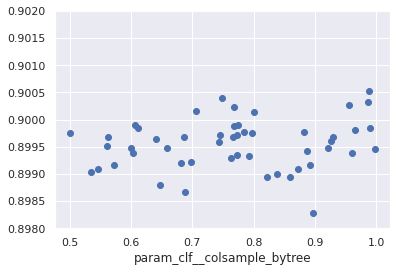

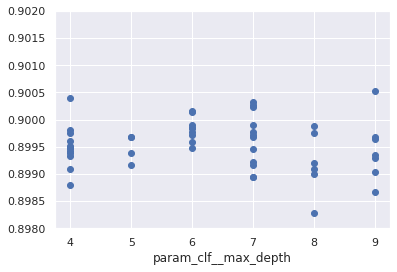

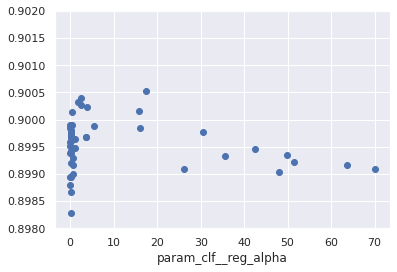

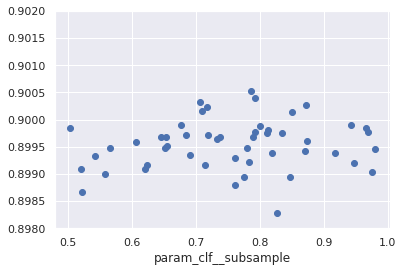

In [16]:
for k in model.cv_results_:
    if k.startswith('param_'):
        plt.scatter(
            model.cv_results_[k].filled(0),
            model.cv_results_['mean_test_score'],
        )
        plt.xlabel(k)
        plt.ylim(.898, .902)
        plt.show()

In [17]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9142
           1       0.69      0.24      0.36      1155

    accuracy                           0.90     10297
   macro avg       0.80      0.61      0.65     10297
weighted avg       0.89      0.90      0.88     10297



In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[9014,  128],
       [ 875,  280]])

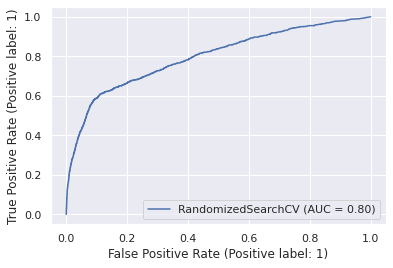

In [20]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)

In [21]:
import shap

In [22]:
explainer = shap.TreeExplainer(model.best_estimator_.named_steps['clf'],)

In [23]:
shap_values = explainer(Xt_test, )

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [24]:
def group_shap(shap_values, X, Xt, column):
    df = Xt.filter(like=column, axis='columns')
    grouping = {c:column for c in df}
    shap_values_g = shap_values.sum(axis=1,grouping=grouping)
    
    idx = shap_values_g.feature_names.index(column)

    shap_values_g.data[:, idx] =  ce.OrdinalEncoder().fit_transform(X_test[column]).values.squeeze()
    
    return shap_values_g

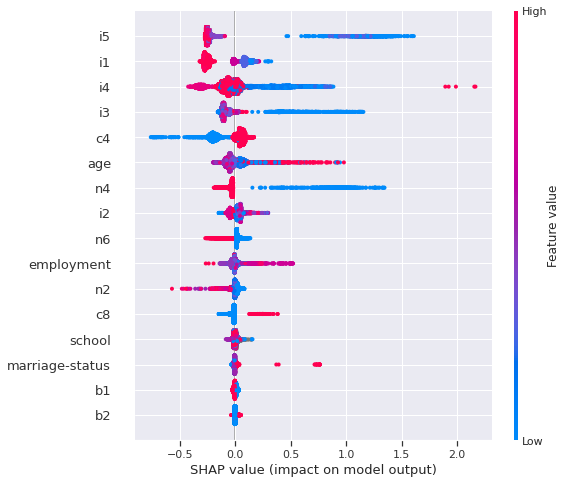

In [25]:
shap_values_g = group_shap(shap_values,  X_test, Xt_test, 'employment')
shap_values_g = group_shap(shap_values_g,  X_test, Xt_test, 'marriage-status')

shap.plots.beeswarm(shap_values_g, max_display=20)

In [26]:
shap_values_g.display_data = X_test[shap_values_g.feature_names].values

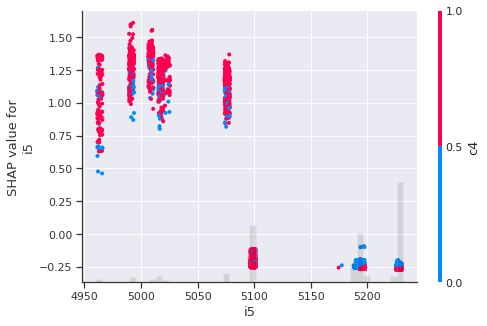

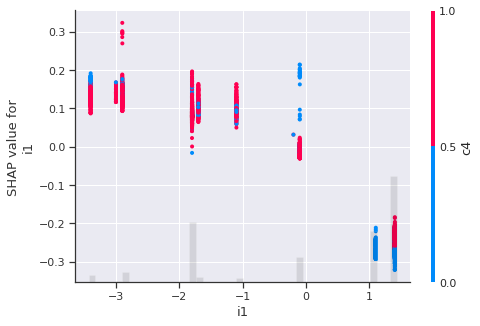

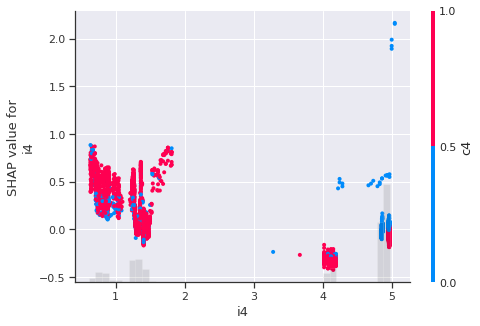

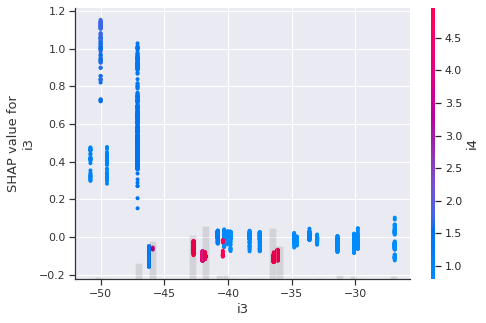

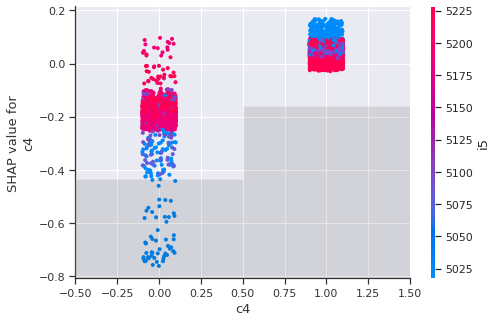

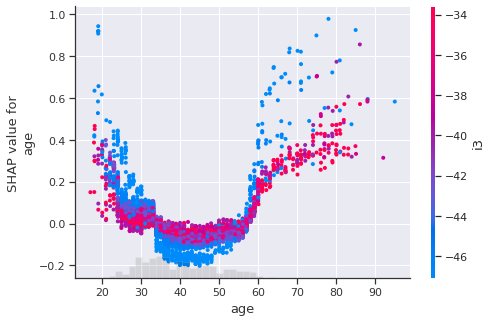

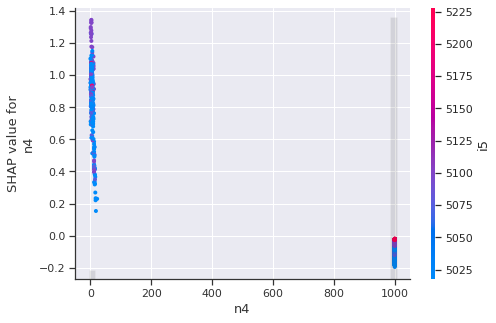

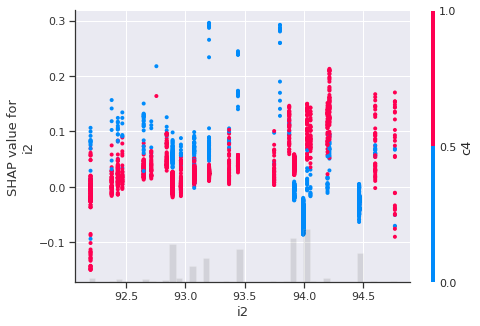

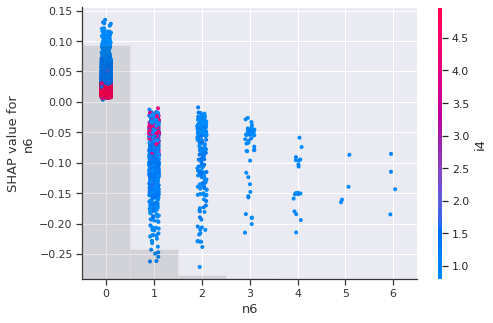

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


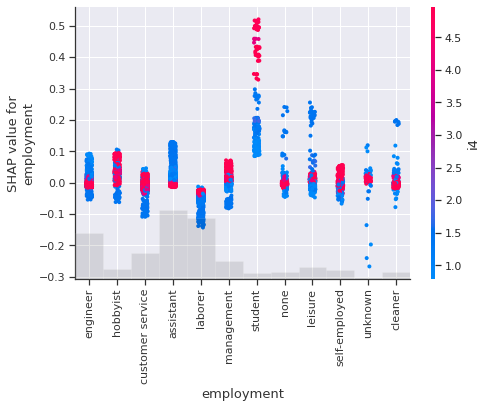

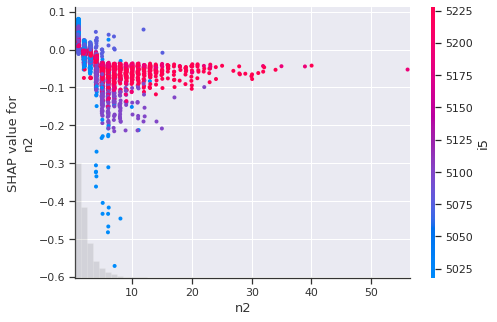

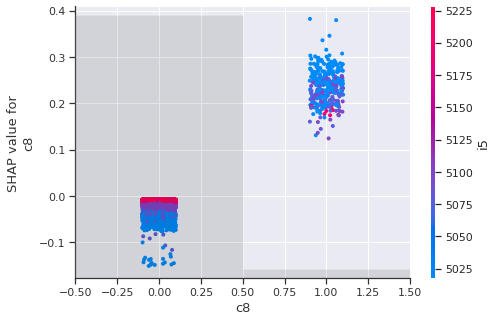

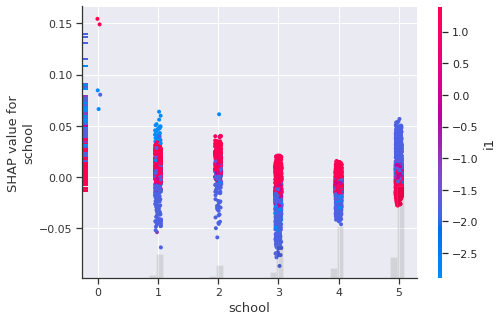

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


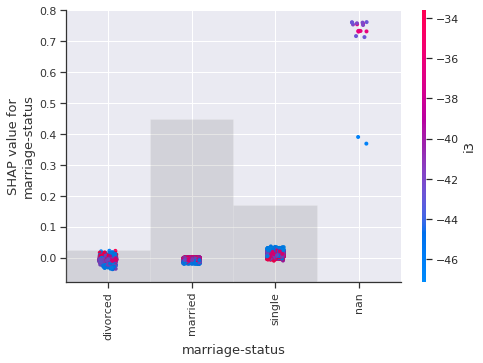

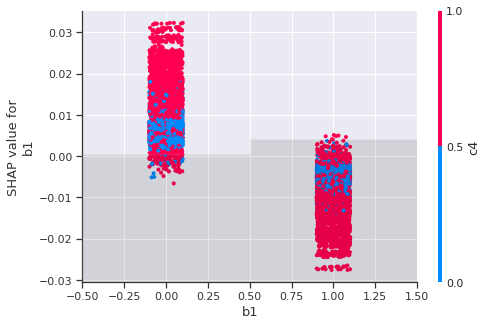

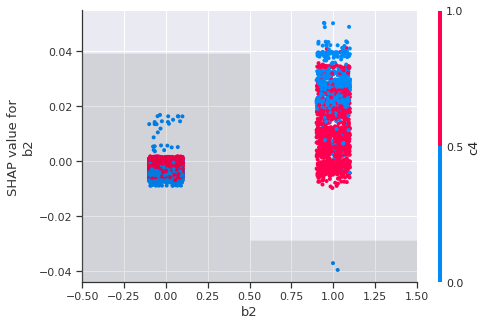

In [27]:
for f in reversed(shap_values_g.abs.sum(0).argsort.values):
    shap.plots.scatter(shap_values_g[:, f], color=shap_values_g)

In [28]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

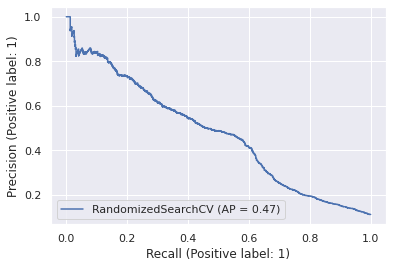

In [29]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(model, X_test, y_test)

In [30]:
scores = pd.DataFrame(dict(successful_sale=y_test, score= y_pred_proba))
scores['score_group'] = pd.qcut(scores.score, 20)

In [31]:
actual = scores.groupby('score_group').successful_sale.mean()
fitted = scores.groupby('score_group').score.mean()
actual /= y_test.mean()
fitted /= y_test.mean()
actual -= 1
fitted -= 1

In [32]:
actual.index = [f'ScoreGroup{i}' for i in range(1, 1+len(actual))]

(-1.0, 20.0)

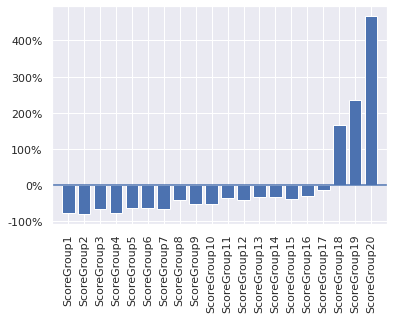

In [33]:
from  matplotlib.ticker import PercentFormatter
plt.bar(actual.index, actual.values)
plt.hlines(0,-1,21)
plt.xticks(rotation=90);
yticks = [-1, 0, 1, 2, 3, 4]
ylabels = [f'{i:.0%}' for i in yticks]
plt.yticks(yticks, ylabels)
plt.xlim(-1,20)

(array([7315.,  920.,  413.,  160.,   79.,   93.,  124.,  227.,  191.,
         153.,  142.,   97.,   80.,   64.,   37.,   27.,   42.,   58.,
          35.,   40.]),
 array([0.03673936, 0.0763068 , 0.11587425, 0.15544169, 0.19500913,
        0.23457657, 0.27414402, 0.31371146, 0.3532789 , 0.39284635,
        0.4324138 , 0.47198123, 0.5115487 , 0.5511161 , 0.5906836 ,
        0.630251  , 0.66981846, 0.7093859 , 0.74895334, 0.78852075,
        0.8280882 ], dtype=float32),
 <BarContainer object of 20 artists>)

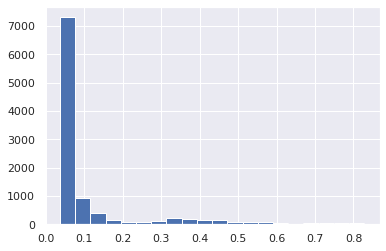

In [34]:
plt.hist(y_pred_proba, bins=20)

In [35]:
sale_rate = scores.sort_values(by='score', ascending=False).successful_sale.cumsum().reset_index(drop=True) / pd.RangeIndex(1,1+len(scores))

unorderd_rate = (scores.successful_sale.cumsum().reset_index(drop=True) / pd.RangeIndex(1,1+len(scores)))

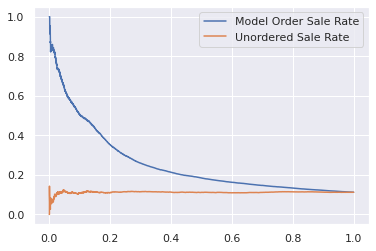

In [36]:
plt.plot(
    np.linspace(0,1,len(scores)),
    sale_rate,
    label = 'Model Order Sale Rate',
)

plt.plot(
    np.linspace(0,1,len(scores)),
    unorderd_rate,
    label = 'Unordered Sale Rate',
)
plt.legend()

In [37]:
qs = np.array([.01, .05, .10, .20, .50])


SalesComp = pd.DataFrame(dict(NumOfCustomers=1000*qs))
SalesComp['ModelOrderSales'] = SalesComp.NumOfCustomers * sale_rate.quantile(q= 1-qs).values
SalesComp['UnOrderSales'] = SalesComp.NumOfCustomers * y_test.mean()
SalesComp["Ratio"] = sale_rate.quantile(q= 1-qs).values / y_test.mean()


SalesComp.round(1)

,NumOfCustomers,ModelOrderSales,UnOrderSales,Ratio
0,10.0,8.4,1.1,7.5
1,50.0,31.8,5.6,5.7
2,100.0,50.6,11.2,4.5
3,200.0,70.4,22.4,3.1
4,500.0,92.1,56.1,1.6
